# Sea Surface Altimetry Data Analysis

For this example we will use [gridded sea-surface altimetry data](http://marine.copernicus.eu/services-portfolio/access-to-products/?option=com_csw&view=details&product_id=SEALEVEL_GLO_PHY_L4_REP_OBSERVATIONS_008_047) from The Copernicus Marine Environment. This is a widely used dataset in physical oceanography and climate.

The dataset has  been extracted from Copernicus and stored in google cloud storage in [xarray-zarr](http://xarray.pydata.org/en/latest/io.html#zarr) format. It is catalogues in the Pangeo Cloud Catalog at https://catalog.pangeo.io/browse/master/ocean/sea_surface_height/

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import hvplot.xarray
plt.rcParams['figure.figsize'] = (15,10)
%matplotlib inline

### Initialize Dataset

Here we load the dataset from the zarr store. Note that this very large dataset initializes nearly instantly, and we can see the full list of variables and coordinates, including metadata for each variable.

In [2]:
from intake import open_catalog
cat = open_catalog("https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/ocean.yaml")
ds  = cat["sea_surface_height"].to_dask()
ds

<xarray.Dataset>
Dimensions:    (latitude: 720, longitude: 1440, nv: 2, time: 8901)
Coordinates:
    crs        int32 ...
    lat_bnds   (time, latitude, nv) float32 dask.array<chunksize=(5, 720, 2), meta=np.ndarray>
  * latitude   (latitude) float32 -89.88 -89.62 -89.38 ... 89.38 89.62 89.88
    lon_bnds   (longitude, nv) float32 dask.array<chunksize=(1440, 2), meta=np.ndarray>
  * longitude  (longitude) float32 0.125 0.375 0.625 0.875 ... 359.4 359.6 359.9
  * nv         (nv) int32 0 1
  * time       (time) datetime64[ns] 1993-01-01 1993-01-02 ... 2017-05-15
Data variables:
    adt        (time, latitude, longitude) float64 dask.array<chunksize=(5, 720, 1440), meta=np.ndarray>
    err        (time, latitude, longitude) float64 dask.array<chunksize=(5, 720, 1440), meta=np.ndarray>
    sla        (time, latitude, longitude) float64 dask.array<chunksize=(5, 720, 1440), meta=np.ndarray>
    ugos       (time, latitude, longitude) float64 dask.array<chunksize=(5, 720, 1440), meta=np.ndarray>
    ugosa      (time, latitude, longitude) float64 dask.array<chunksize=(5, 720, 1440), meta=np.ndarray>
    vgos       (time, latitude, longitude) float64 dask.array<chunksize=(5, 720, 1440), meta=np.ndarray>
    vgosa      (time, latitude, longitude) float64 dask.array<chunksize=(5, 720, 1440), meta=np.ndarray>
Attributes:
    Conventions:                     CF-1.6
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    cdm_data_type:                   Grid
    comment:                         Sea Surface Height measured by Altimetry...
    contact:                         servicedesk.cmems@mercator-ocean.eu
    creator_email:                   servicedesk.cmems@mercator-ocean.eu
    creator_name:                    CMEMS - Sea Level Thematic Assembly Center
    creator_url:                     http://marine.copernicus.eu
    date_created:                    2014-02-26T16:09:13Z
    date_issued:                     2014-01-06T00:00:00Z
    date_modified:                   2015-11-10T19:42:51Z
    geospatial_lat_max:              89.875
    geospatial_lat_min:              -89.875
    geospatial_lat_resolution:       0.25
    geospatial_lat_units:            degrees_north
    geospatial_lon_max:              359.875
    geospatial_lon_min:              0.125
    geospatial_lon_resolution:       0.25
    geospatial_lon_units:            degrees_east
    geospatial_vertical_max:         0.0
    geospatial_vertical_min:         0.0
    geospatial_vertical_positive:    down
    geospatial_vertical_resolution:  point
    geospatial_vertical_units:       m
    history:                         2014-02-26T16:09:13Z: created by DUACS D...
    institution:                     CLS, CNES
    keywords:                        Oceans > Ocean Topography > Sea Surface ...
    keywords_vocabulary:             NetCDF COARDS Climate and Forecast Stand...
    license:                         http://marine.copernicus.eu/web/27-servi...
    platform:                        ERS-1, Topex/Poseidon
    processing_level:                L4
    product_version:                 5.0
    project:                         COPERNICUS MARINE ENVIRONMENT MONITORING...
    references:                      http://marine.copernicus.eu
    source:                          Altimetry measurements
    ssalto_duacs_comment:            The reference mission used for the altim...
    standard_name_vocabulary:        NetCDF Climate and Forecast (CF) Metadat...
    summary:                         SSALTO/DUACS Delayed-Time Level-4 sea su...
    time_coverage_duration:          P1D
    time_coverage_end:               1993-01-01T12:00:00Z
    time_coverage_resolution:        P1D
    time_coverage_start:             1992-12-31T12:00:00Z
    title:                           DT merged all satellites Global Ocean Gr...

## Visually Examine Some of the Data

Let's do a sanity check that the data looks reasonable. Here we use the [hvplot](https://hvplot.holoviz.org/index.html) interactive plotting library.

In [3]:
ds.sla.hvplot.image('longitude', 'latitude',
                    rasterize=True, dynamic=True, width=800, height=450, 
                    widget_type='scrubber', widget_location='bottom', cmap='RdBu_r')

Column
    [0] HoloViews(DynamicMap, widget_location='bottom', widget_type='scrubber')
    [1] Row
        [0] HSpacer()
        [1] WidgetBox
            [0] Player(end=8900, width=550)
        [2] HSpacer()

### Create and Connect to Dask Distributed Cluster

In [4]:
from dask_gateway import Gateway
from dask.distributed import Client

gateway = Gateway()
cluster = gateway.new_cluster()
cluster.adapt(minimum=1, maximum=20)
cluster

** ☝️ Don't forget to click the link above to view the scheduler dashboard! **

In [5]:
client = Client(cluster)
client

<Client: 'tls://10.48.158.8:8786' processes=0 threads=0, memory=0 B>

## Timeseries of Global Mean Sea Level

Here we make a simple yet fundamental calculation: the rate of increase of global mean sea level over the observational period.

In [6]:
# the number of GB involved in the reduction
ds.sla.nbytes/1e9

73.8284544

In [7]:
# the computationally intensive step
sla_timeseries = ds.sla.mean(dim=('latitude', 'longitude')).load()

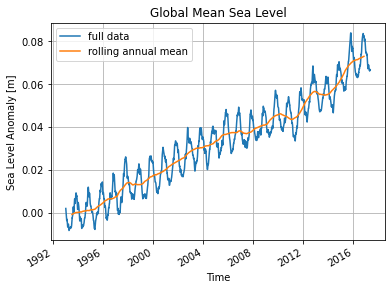

In [8]:
sla_timeseries.plot(label='full data')
sla_timeseries.rolling(time=365, center=True).mean().plot(label='rolling annual mean')
plt.ylabel('Sea Level Anomaly [m]')
plt.title('Global Mean Sea Level')
plt.legend()
plt.grid()

In order to understand how the sea level rise is distributed in latitude, we can make a sort of [Hovmöller diagram](https://en.wikipedia.org/wiki/Hovm%C3%B6ller_diagram).

In [9]:
sla_hov = ds.sla.mean(dim='longitude').load()

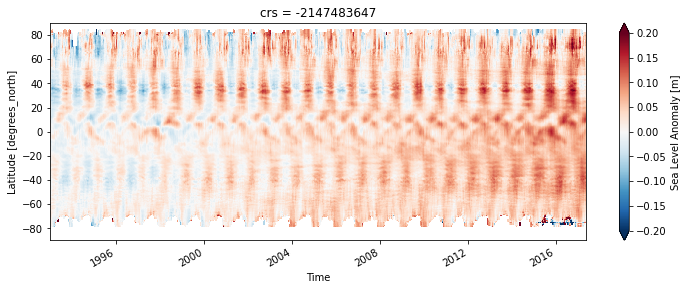

In [10]:
fig, ax = plt.subplots(figsize=(12, 4))
sla_hov.name = 'Sea Level Anomaly [m]'
sla_hov.transpose().plot(vmax=0.2, ax=ax)

We can see that most sea level rise is actually in the Southern Hemisphere.

## Sea Level Variability

We can examine the natural variability in sea level by looking at its standard deviation in time.

In [11]:
sla_std = ds.sla.std(dim='time').load()
sla_std.name = 'Sea Level Variability [m]'

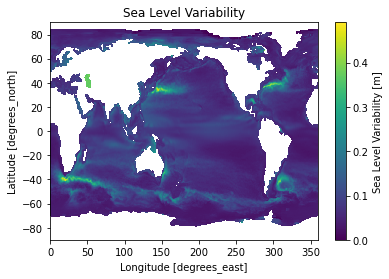

In [12]:
ax = sla_std.plot()
_ = plt.title('Sea Level Variability')